In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.layers import Input,GlobalMaxPooling2D,Dense
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator

2024-04-26 19:59:21.585491: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-04-26 19:59:23.562540: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
DATASET = './dataset'  # path to the dataset
SPLITTED_DATASET = DATASET+'_splitted'

CLASS_NAMES = np.array([item for item in os.listdir(DATASET) if os.path.isdir(os.path.join(DATASET, item))])
NUM_CLASSES = len(CLASS_NAMES)

MODEL = 'mobilenet_v2' # mobilenet_v2, resnet50, vgg16 or inception_v3
SIZE = 224  # Image resolution
BATCH_SIZE = 32  # size of the readed batches from generator (must fit on system memory)
VAL_SPLIT = 0.15  # fraction of the images used for validation
TEST_SPLIT = 0.15  # fraction of the images used for testing
SAVED_MODEL_NAME = 'trained_'+MODEL+str(SIZE) # Name for the saved model




# Import desired model and preprocess function
# Could use switch if pyython>=3.10
if MODEL == 'mobilenet_v2':
    from tensorflow.keras.applications.mobilenet_v2 import MobileNetV2 as model, preprocess_input
elif MODEL == 'resnet50':
    from tensorflow.keras.applications.resnet50 import ResNet50 as model, preprocess_input
elif MODEL == 'vgg16':
    from tensorflow.keras.applications.vgg16 import VGG16 as model, preprocess_input
elif MODEL == 'inception_v3':
    from tensorflow.keras.applications.inception_v3 import InceptionV3 as model, preprocess_input
else:
    print('Select a valid model')
    exit(0)

Found 2796 images belonging to 4 classes.
Found 597 images belonging to 4 classes.
Found 604 images belonging to 4 classes.


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Images is shape (32, 224, 224, 3)


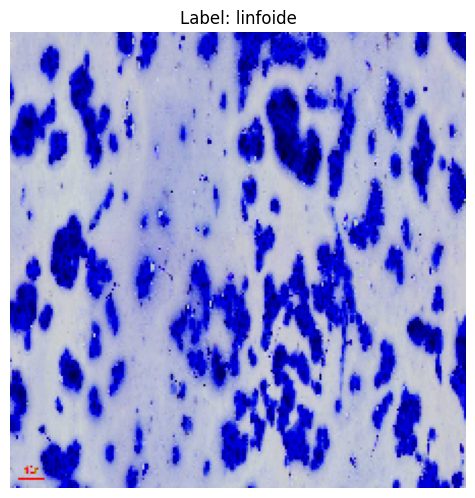

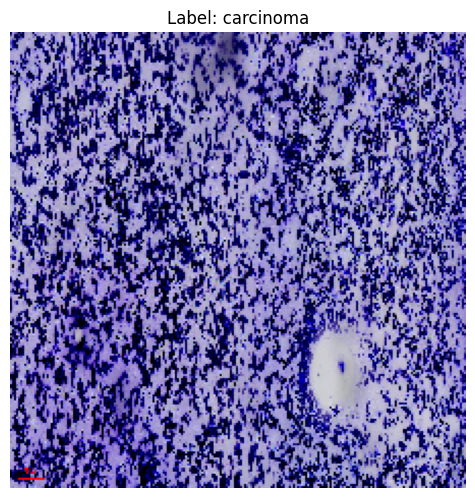

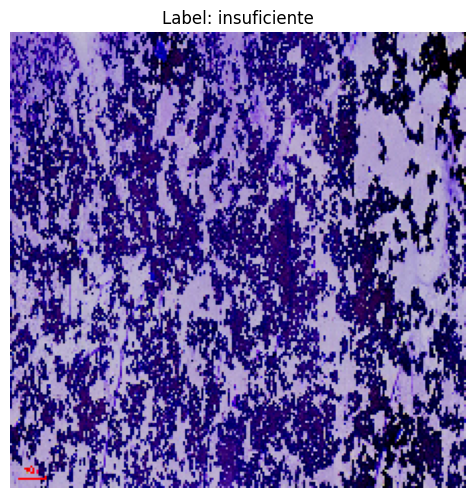

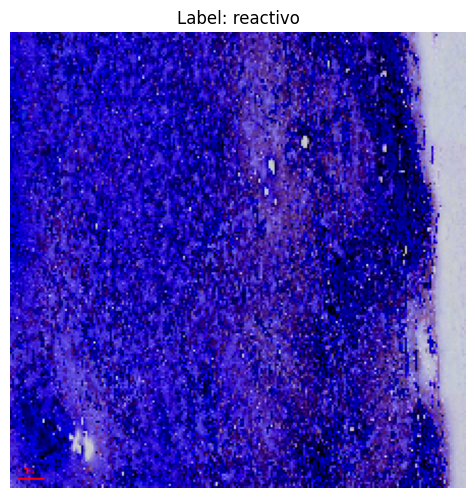

<function matplotlib.pyplot.show(close=None, block=None)>

In [3]:
##########           Image generators           ##########

# Just execute when you need to generate the splitted data. Comment if not.
import splitfolders
splitfolders.ratio(DATASET, seed=123, output=SPLITTED_DATASET, ratio=(1-VAL_SPLIT-TEST_SPLIT, VAL_SPLIT, TEST_SPLIT))


train_datagen = ImageDataGenerator(#rescale=1./255, # preprocess_input() already does it ¿?
                                    #rotation_range = 5,
                                    #shear_range=0.2,
                                    #zoom_range=0.2,
                                    #width_shift_range=0.0,
                                    #height_shift_range=0.0,
                                    fill_mode='wrap',
                                    #brightness_range=None,
                                    #horizontal_flip=True,
                                    #vertical_flip=True,
                                    preprocessing_function=preprocess_input
                                  )
train_generator = train_datagen.flow_from_directory(SPLITTED_DATASET+'/train',
                                                    batch_size=BATCH_SIZE,
                                                    class_mode='categorical',
                                                    shuffle=True,
                                                    target_size=(SIZE,SIZE)
                                                    )


# ImageDataGenerator for validation and test, we can't use the previous one because alidation data should't be augmented
val_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)

validation_generator = val_datagen.flow_from_directory(SPLITTED_DATASET+'/val',
                                                         batch_size=BATCH_SIZE,
                                                         class_mode='categorical',
                                                         shuffle=True,
                                                         target_size=(SIZE,SIZE)
                                                    )
test_generator = val_datagen.flow_from_directory(SPLITTED_DATASET+'/test',
                                                         batch_size=BATCH_SIZE,
                                                         class_mode='categorical',
                                                         shuffle=True,
                                                         target_size=(SIZE,SIZE)
                                                    )

# Get a test batch from the generator to ensure images are loaded ok
images, labels = train_generator.__next__()
print('Images is shape', images.shape)
    
for i in range(4):
    f = plt.figure(figsize = (20, 20))
    f.add_subplot(1,3,1)
    plt.axis('off')
    plt.title('Label: '+str(CLASS_NAMES[np.argmax(labels[i])]))
    plt.imshow(images[i])
plt.show(block=True)
plt.show

In [4]:
##########          CNN Construction           ##########

IMG_SHAPE = (SIZE, SIZE, 3)

# Create the base model from the pre-trained model
base_model = model(input_shape=IMG_SHAPE,
                    include_top=False,
                    weights='imagenet')

base_model.trainable = False

# Add a classification head
x = base_model.output
x = GlobalMaxPooling2D()(x)
x = Dense(1024, activation='relu')(x)
predictions = Dense(NUM_CLASSES, activation='softmax')(x)

# This is the model we will train
model = Model(inputs=base_model.input, outputs=predictions)

metrics = ['accuracy', 'AUC', 'Precision', 'Recall', 'TruePositives', 'TrueNegatives', 'FalsePositives', 'FalseNegatives']

model.compile(optimizer='adam',
                loss='categorical_crossentropy',
                metrics=metrics
             )

In [5]:
##########           Training           ##########

early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=3, min_delta=0.01, restore_best_weights=True)

history = model.fit(train_generator,
                    epochs=20,
                    validation_data=validation_generator,
                    callbacks=[early_stop]
                   )

save_path = './trained_models/'+SAVED_MODEL_NAME+'.keras'
print('Saving model to:', save_path)
model.save(save_path)

Epoch 1/20
88/88 [==============================] - 202s 2s/step - loss: 1.5653 - accuracy: 0.8101 - auc: 0.9286 - precision: 0.8148 - recall: 0.8072 - true_positives: 2257.0000 - true_negatives: 7875.0000 - false_positives: 513.0000 - false_negatives: 539.0000 - val_loss: 0.2566 - val_accuracy: 0.9162 - val_auc: 0.9858 - val_precision: 0.9247 - val_recall: 0.9045 - val_true_positives: 540.0000 - val_true_negatives: 1747.0000 - val_false_positives: 44.0000 - val_false_negatives: 57.0000
Epoch 2/20
88/88 [==============================] - 194s 2s/step - loss: 0.2180 - accuracy: 0.9242 - auc: 0.9895 - precision: 0.9286 - recall: 0.9210 - true_positives: 2575.0000 - true_negatives: 8190.0000 - false_positives: 198.0000 - false_negatives: 221.0000 - val_loss: 0.2390 - val_accuracy: 0.9263 - val_auc: 0.9884 - val_precision: 0.9293 - val_recall: 0.9246 - val_true_positives: 552.0000 - val_true_negatives: 1749.0000 - val_false_positives: 42.0000 - val_false_negatives: 45.0000
Epoch 3/20
88/88

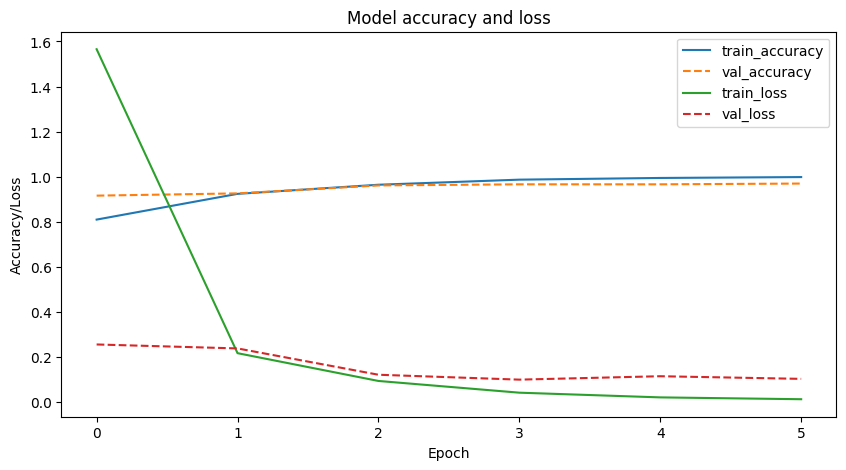

In [7]:
# Plot training & validation accuracy and loss values in a single plot with the four metrics
plt.figure(figsize=(10, 5))
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'], linestyle='dashed')
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'], linestyle='dashed')

plt.title('Model accuracy and loss')
plt.ylabel('Accuracy/Loss')
plt.xlabel('Epoch')
plt.legend(['train_accuracy', 'val_accuracy', 'train_loss', 'val_loss'], loc='best')



In [8]:
#########           Model test           ##########
from keras.models import load_model

'''
path = './trained_models/'+SAVED_MODEL_NAME+'.keras'
model = load_model(path, compile=True)
    
val_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)

test_generator = val_datagen.flow_from_directory(SPLITTED_DATASET+'/test',
                                                         batch_size=BATCH_SIZE,
                                                         class_mode='categorical',
                                                         shuffle=True,
                                                         target_size=(SIZE,SIZE)
                                                    )

'''

# Evaluate on Validation data
scores = model.evaluate(test_generator)

for name, value in zip(model.metrics_names, scores):
  print(name, ': ', value)

19/19 [==============================] - 35s 2s/step - loss: 0.1384 - accuracy: 0.9437 - auc: 0.9958 - precision: 0.9499 - recall: 0.9421 - true_positives: 569.0000 - true_negatives: 1782.0000 - false_positives: 30.0000 - false_negatives: 35.0000
loss :  0.13839158415794373
accuracy :  0.943708598613739
auc :  0.9957535266876221
precision :  0.9499165415763855
recall :  0.942052960395813
true_positives :  569.0
true_negatives :  1782.0
false_positives :  30.0
false_negatives :  35.0


# Support code

### Detect and remove corrupted images from the dataset

In [10]:
from PIL import Image
import os
import numpy as np

def is_valid_image(file_path):
    try:
        i = Image.open(file_path)
        valid = True
    except:
        valid = False
    return valid

def detect_corrupted_images(dataset_path):
    corrupted_images = []
    for root, dirs, files in os.walk(dataset_path):
        for file in files:
            file_path = os.path.join(root, file)
            if not is_valid_image(file_path):
                corrupted_images.append(file_path)
    return corrupted_images


DATASET='dataset'
corrupted_images = detect_corrupted_images(DATASET)
print('Number of corrupted images:', len(corrupted_images))
print(corrupted_images)

# Remove corrupted images
for image in corrupted_images:
    os.remove(image)


Number of corrupted images: 0
[]
